In [60]:
!pip install pandas seaborn

In [61]:
import pandas as pd
import seaborn as sns
import os
import glob
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Performance Analysis - Distributed Computing Benchmarks

This notebook analyzes performance metrics from distributed computing benchmarks across three scaling scenarios:
- **Strong Scaling (SS)**: Fixed problem size with increasing resources
- **Weak Scaling (WS)**: Problem size scales proportionally with resources
- **Worker Sweep (W-)**: Analysis across different worker configurations

## 1. Load and Categorize Data

In [94]:
# Load and categorize CSV files
LOG_DIR = "/home/amber-intel/ritik/iisc-deas-project-1/logs/6767P/reduced-runs-new-config"

csv_files = glob.glob(os.path.join(LOG_DIR, "*.csv"))

strong_scaling_files = [f for f in csv_files if os.path.basename(f).startswith('SS')]
weak_scaling_files = [f for f in csv_files if os.path.basename(f).startswith('WS')]
worker_sweep_files = [f for f in csv_files if os.path.basename(f).startswith('W-')]

def read_and_combine(file_list):
    if not file_list:
        return pd.DataFrame()
    dfs = [pd.read_csv(f) for f in file_list]
    return pd.concat(dfs, ignore_index=True)

df_strong_scaling = read_and_combine(strong_scaling_files)
df_weak_scaling = read_and_combine(weak_scaling_files)
df_worker_sweep = read_and_combine(worker_sweep_files)

print(f"Loaded - Strong Scaling: {len(df_strong_scaling)}, Weak Scaling: {len(df_weak_scaling)}, Worker Sweep: {len(df_worker_sweep)}")

Loaded - Strong Scaling: 6, Weak Scaling: 6, Worker Sweep: 5


In [95]:
# Calculate stage metrics
def calculate_stage_metrics(df):
    df = df.copy()
    
    stage_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_time')]
    stage_throughput_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_throughput')]
    executor_run_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_executorRunTime')]
    executor_cpu_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_executorCpuTime')]
    jvm_gc_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_jvmGCTime')]
    
    df['total_stage_time'] = df[stage_time_cols].sum(axis=1)
    df['average_stage_throughput'] = df[stage_throughput_cols].mean(axis=1)
    df['Total_Executor_Run_Time'] = df[executor_run_time_cols].sum(axis=1)
    df['Total_Executor_CPU_Time'] = df[executor_cpu_time_cols].sum(axis=1)
    df['Total_JVM_GC_Time'] = df[jvm_gc_time_cols].sum(axis=1)
    
    return df

df_strong_scaling = calculate_stage_metrics(df_strong_scaling)
df_weak_scaling = calculate_stage_metrics(df_weak_scaling)
df_worker_sweep = calculate_stage_metrics(df_worker_sweep)

print("Metrics calculated")

Metrics calculated


## 2. Strong Scaling Analysis - Amdahl's Law

Analyzing how the system performs with fixed problem size and increasing computing resources. Speedup is calculated as T1/Tn where T1 is the baseline execution time.

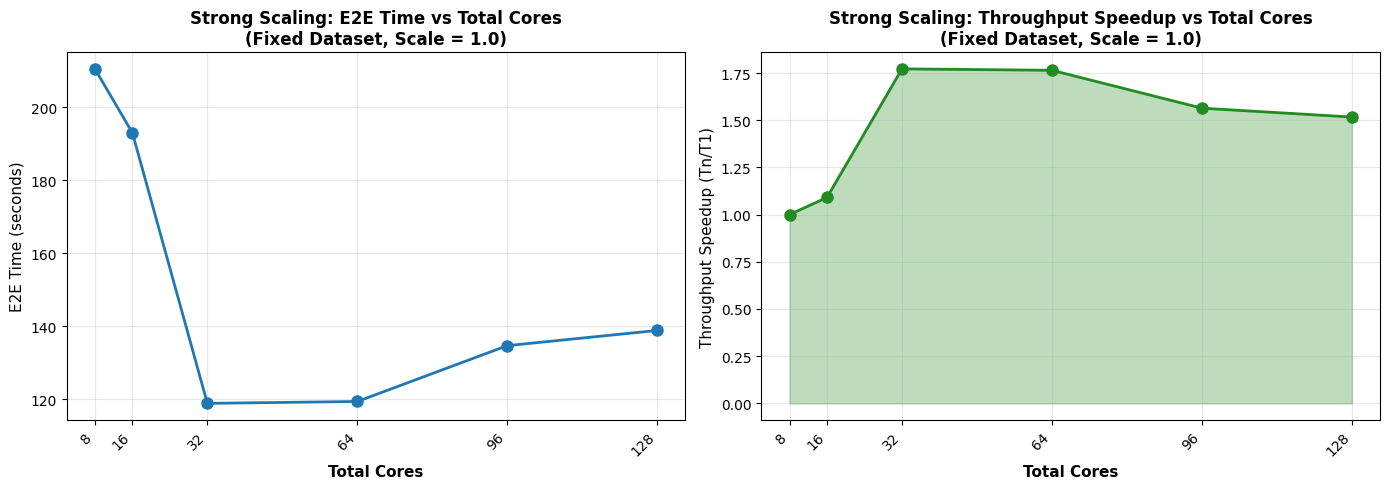

Strong Scaling Performance:
----------------------------------------------------------------------------------------------------
1W-8C      | Cores:   8 | Throughput:   3765.5 records/sec | Speedup: 1.00x
2W-8C      | Cores:  16 | Throughput:   4107.7 records/sec | Speedup: 1.09x
4W-8C      | Cores:  32 | Throughput:   6672.4 records/sec | Speedup: 1.77x
8W-8C      | Cores:  64 | Throughput:   6643.6 records/sec | Speedup: 1.76x
12W-8C     | Cores:  96 | Throughput:   5888.0 records/sec | Speedup: 1.56x
16W-8C     | Cores: 128 | Throughput:   5711.4 records/sec | Speedup: 1.52x


In [96]:
import matplotlib.pyplot as plt

df_ss = df_strong_scaling.copy()

df_ss['config_name'] = (
    df_ss['num_workers'].astype(str) + 'W-' +
    df_ss['cores_per_worker'].astype(str) + 'C'
)

df_ss['total_cores'] = df_ss['num_workers'] * df_ss['cores_per_worker']
df_ss = df_ss.sort_values('total_cores')

throughput_1 = df_ss.iloc[0]['E2E_throughput']
df_ss['speedup'] = df_ss['E2E_throughput'] / throughput_1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_ss['total_cores'], df_ss['E2E_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xticks(df_ss['total_cores'])
ax1.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=11)
ax1.set_title('Strong Scaling: E2E Time vs Total Cores\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(df_ss['total_cores'], df_ss['speedup'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(df_ss['total_cores'], df_ss['speedup'], alpha=0.3, color='forestgreen')
ax2.set_xticks(df_ss['total_cores'])
ax2.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax2.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax2.set_ylabel('Throughput Speedup (Tn/T1)', fontsize=11)
ax2.set_title('Strong Scaling: Throughput Speedup vs Total Cores\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Strong Scaling Performance:")
print("-" * 100)
for _, row in df_ss.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Throughput: {row['E2E_throughput']:8.1f} records/sec | Speedup: {row['speedup']:.2f}x")

## 3. Strong Scaling - Executor time Analysis

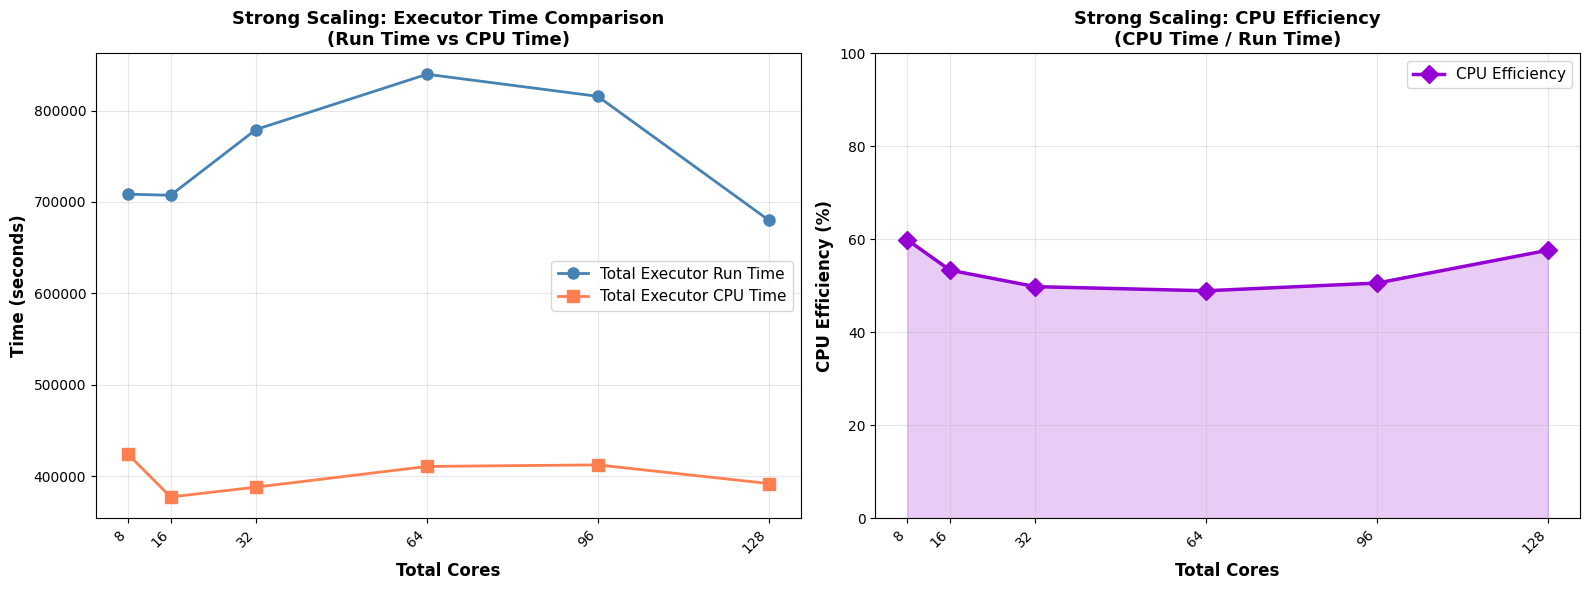


Strong Scaling - Executor Time Analysis:
Cores    Executor Run Time    Executor CPU Time    CPU Efficiency (%)  
----------------------------------------------------------------------------------------------------
8                 708466.00s          423972.00s              59.84%
16                707313.00s          377147.00s              53.32%
32                779257.00s          387894.00s              49.78%
64                839705.00s          410551.00s              48.89%
96                815565.00s          412239.00s              50.55%
128               680185.00s          391831.00s              57.61%


In [97]:
# Executor Time Analysis for Strong Scaling
df_ss_exec = df_strong_scaling.copy()

# Ensure we have the necessary columns
if 'total_cores' not in df_ss_exec.columns:
    df_ss_exec['total_cores'] = df_ss_exec['num_workers'] * df_ss_exec['cores_per_worker']

df_ss_exec = df_ss_exec.sort_values('total_cores')

# Calculate CPU Efficiency
df_ss_exec['CPU_Efficiency'] = (df_ss_exec['Total_Executor_CPU_Time'] / df_ss_exec['Total_Executor_Run_Time']) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: Total Executor Run Time and Total Executor CPU Time
ax1.plot(df_ss_exec['total_cores'], df_ss_exec['Total_Executor_Run_Time'], 
         marker='o', linewidth=2, markersize=8, label='Total Executor Run Time', color='steelblue')
ax1.plot(df_ss_exec['total_cores'], df_ss_exec['Total_Executor_CPU_Time'], 
         marker='s', linewidth=2, markersize=8, label='Total Executor CPU Time', color='coral')
ax1.set_xticks(df_ss_exec['total_cores'])
ax1.set_xticklabels(df_ss_exec['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Strong Scaling: Executor Time Comparison\n(Run Time vs CPU Time)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Graph 2: CPU Efficiency
ax2.plot(df_ss_exec['total_cores'], df_ss_exec['CPU_Efficiency'], 
         marker='D', linewidth=2.5, markersize=9, color='darkviolet', label='CPU Efficiency')
ax2.fill_between(df_ss_exec['total_cores'], df_ss_exec['CPU_Efficiency'], alpha=0.2, color='darkviolet')
ax2.set_xticks(df_ss_exec['total_cores'])
ax2.set_xticklabels(df_ss_exec['total_cores'], rotation=45, ha='right')
ax2.set_xlabel('Total Cores', fontsize=12, fontweight='bold')
ax2.set_ylabel('CPU Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Strong Scaling: CPU Efficiency\n(CPU Time / Run Time)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nStrong Scaling - Executor Time Analysis:")
print("=" * 100)
print(f"{'Cores':<8} {'Executor Run Time':<20} {'Executor CPU Time':<20} {'CPU Efficiency (%)':<20}")
print("-" * 100)
for _, row in df_ss_exec.iterrows():
    print(f"{row['total_cores']:<8} {row['Total_Executor_Run_Time']:>18.2f}s {row['Total_Executor_CPU_Time']:>18.2f}s {row['CPU_Efficiency']:>18.2f}%")

## 4. Weak Scaling Analysis - Gustafson's Law

Analyzing how the system handles increasing problem sizes proportionally with computing resources. In weak scaling, both dataset scale and core count increase together.

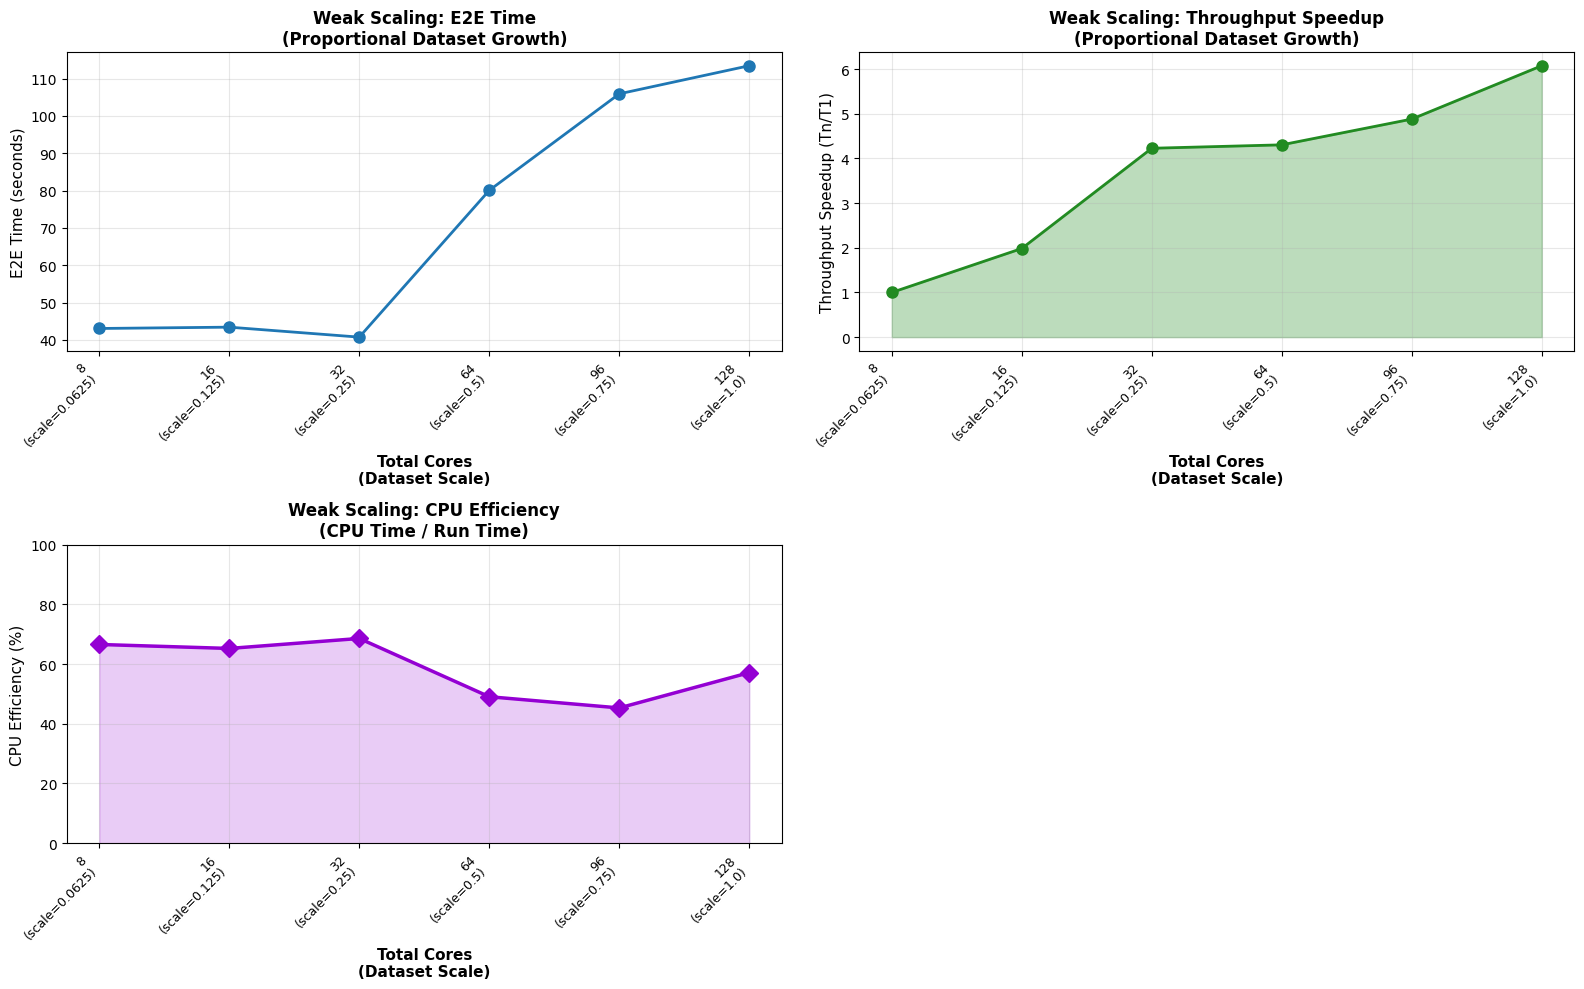

Weak Scaling Performance:
------------------------------------------------------------------------------------------------------------------------
1W-8C      | Cores:   8 | Scale:  0.1 | E2E Time:   43.07s | Throughput:   1150.7 records/sec | Speedup: 1.00x | CPU Eff: 66.56%
2W-8C      | Cores:  16 | Scale:  0.1 | E2E Time:   43.43s | Throughput:   2282.6 records/sec | Speedup: 1.98x | CPU Eff: 65.23%
4W-8C      | Cores:  32 | Scale:  0.2 | E2E Time:   40.76s | Throughput:   4864.3 records/sec | Speedup: 4.23x | CPU Eff: 68.57%
8W-8C      | Cores:  64 | Scale:  0.5 | E2E Time:   80.06s | Throughput:   4952.5 records/sec | Speedup: 4.30x | CPU Eff: 49.06%
12W-8C     | Cores:  96 | Scale:  0.8 | E2E Time:  105.91s | Throughput:   5615.8 records/sec | Speedup: 4.88x | CPU Eff: 45.31%
16W-8C     | Cores: 128 | Scale:  1.0 | E2E Time:  113.44s | Throughput:   6990.6 records/sec | Speedup: 6.07x | CPU Eff: 57.13%


In [98]:
df_ws = df_weak_scaling.copy()

df_ws['config_name'] = (
    df_ws['num_workers'].astype(str) + 'W-' +
    df_ws['cores_per_worker'].astype(str) + 'C'
)

df_ws['total_cores'] = df_ws['num_workers'] * df_ws['cores_per_worker']
df_ws = df_ws.sort_values('total_cores')

df_ws['x_label'] = df_ws['total_cores'].astype(str) + '\n(scale=' + df_ws['dataset_scale'].astype(str) + ')'

throughput_1 = df_ws.iloc[0]['E2E_throughput']
df_ws['speedup'] = df_ws['E2E_throughput'] / throughput_1

# Calculate CPU Efficiency
df_ws['CPU_Efficiency'] = (df_ws['Total_Executor_CPU_Time'] / df_ws['Total_Executor_Run_Time']) * 100

fig, ((ax1, ax2), (ax3, ax_empty)) = plt.subplots(2, 2, figsize=(16, 10))

x_positions = range(len(df_ws))

# Chart 1: E2E Time
ax1.plot(x_positions, df_ws['E2E_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax1.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=11)
ax1.set_title('Weak Scaling: E2E Time\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Chart 2: Throughput Speedup
ax2.plot(x_positions, df_ws['speedup'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(x_positions, df_ws['speedup'], alpha=0.3, color='forestgreen')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Throughput Speedup (Tn/T1)', fontsize=11)
ax2.set_title('Weak Scaling: Throughput Speedup\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Chart 3: CPU Efficiency
ax3.plot(x_positions, df_ws['CPU_Efficiency'], marker='D', linewidth=2.5, markersize=9, color='darkviolet')
ax3.fill_between(x_positions, df_ws['CPU_Efficiency'], alpha=0.2, color='darkviolet')
ax3.set_xticks(x_positions)
ax3.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax3.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax3.set_ylabel('CPU Efficiency (%)', fontsize=11)
ax3.set_title('Weak Scaling: CPU Efficiency\n(CPU Time / Run Time)', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

# Hide the empty subplot
ax_empty.axis('off')

plt.tight_layout()
plt.show()

print("Weak Scaling Performance:")
print("-" * 120)
for _, row in df_ws.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Scale: {row['dataset_scale']:4.1f} | "
          f"E2E Time: {row['E2E_time']:7.2f}s | Throughput: {row['E2E_throughput']:8.1f} records/sec | "
          f"Speedup: {row['speedup']:.2f}x | CPU Eff: {row['CPU_Efficiency']:.2f}%")

## 5. Stage Throughput Comparison: Strong vs Weak Scaling

Comparing average stage throughput between strong scaling (fixed dataset) and weak scaling (proportional dataset growth).

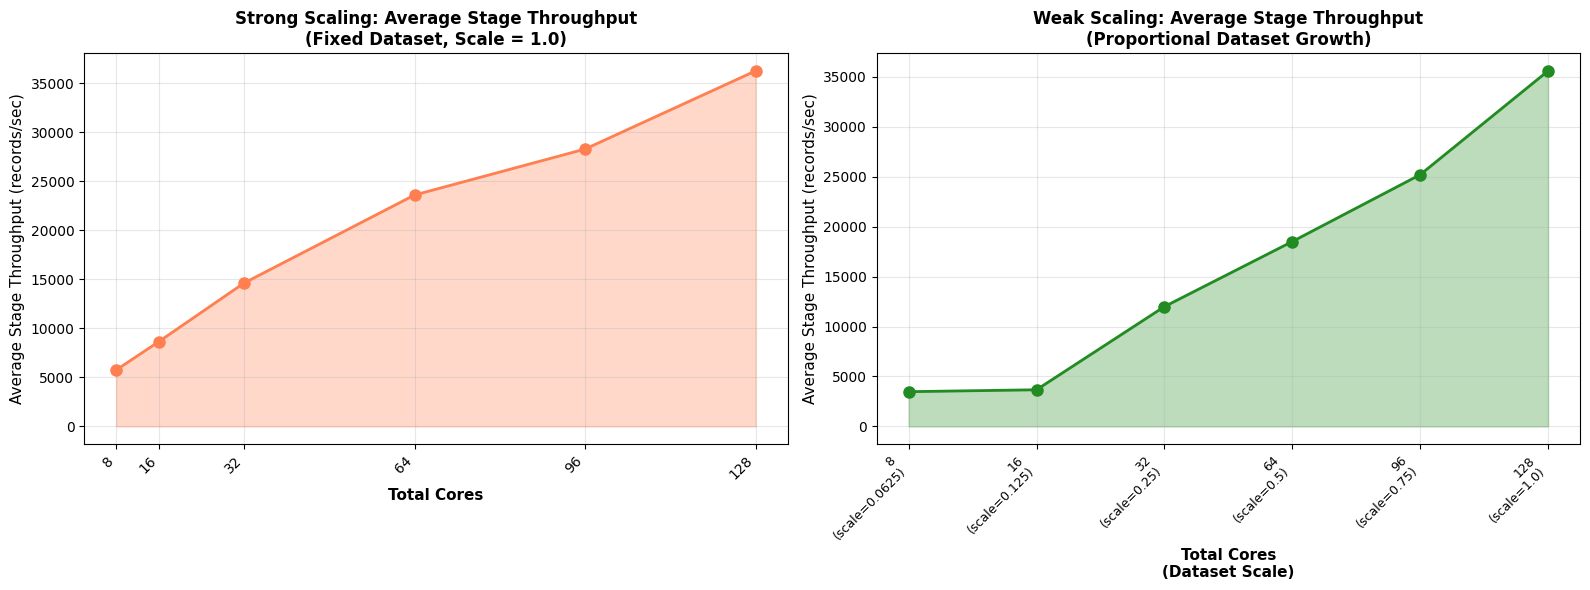


Stage Throughput Comparative Analysis:

Strong Scaling (Fixed Dataset):
------------------------------------------------------------------------------------------
1W-8C      | Cores:   8 | Avg Stage Throughput:   5751.3 records/sec
2W-8C      | Cores:  16 | Avg Stage Throughput:   8648.4 records/sec
4W-8C      | Cores:  32 | Avg Stage Throughput:  14624.6 records/sec
8W-8C      | Cores:  64 | Avg Stage Throughput:  23605.2 records/sec
12W-8C     | Cores:  96 | Avg Stage Throughput:  28292.0 records/sec
16W-8C     | Cores: 128 | Avg Stage Throughput:  36264.4 records/sec

Weak Scaling (Proportional Dataset):
------------------------------------------------------------------------------------------
1W-8C      | Cores:   8 | Scale:  0.1 | Avg Stage Throughput:   3479.1 records/sec
2W-8C      | Cores:  16 | Scale:  0.1 | Avg Stage Throughput:   3669.2 records/sec
4W-8C      | Cores:  32 | Scale:  0.2 | Avg Stage Throughput:  11995.1 records/sec
8W-8C      | Cores:  64 | Scale:  0.5 | Avg 

In [99]:
# Combined visualization: Average Stage Throughput for Strong and Weak Scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Strong Scaling - Average Stage Throughput
ax1.plot(df_ss['total_cores'], df_ss['average_stage_throughput'], marker='o', linewidth=2, markersize=8, color='coral')
ax1.fill_between(df_ss['total_cores'], df_ss['average_stage_throughput'], alpha=0.3, color='coral')
ax1.set_xticks(df_ss['total_cores'])
ax1.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Stage Throughput (records/sec)', fontsize=11)
ax1.set_title('Strong Scaling: Average Stage Throughput\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Chart 2: Weak Scaling - Average Stage Throughput
x_positions_ws = range(len(df_ws))
ax2.plot(x_positions_ws, df_ws['average_stage_throughput'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(x_positions_ws, df_ws['average_stage_throughput'], alpha=0.3, color='forestgreen')
ax2.set_xticks(x_positions_ws)
ax2.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Stage Throughput (records/sec)', fontsize=11)
ax2.set_title('Weak Scaling: Average Stage Throughput\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparative analysis
print("\nStage Throughput Comparative Analysis:")
print("=" * 90)
print("\nStrong Scaling (Fixed Dataset):")
print("-" * 90)
for _, row in df_ss.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Avg Stage Throughput: {row['average_stage_throughput']:8.1f} records/sec")

print("\nWeak Scaling (Proportional Dataset):")
print("-" * 90)
for _, row in df_ws.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Scale: {row['dataset_scale']:4.1f} | Avg Stage Throughput: {row['average_stage_throughput']:8.1f} records/sec")

## 5. Worker Sweep Analysis

Analyzing the impact of different worker configurations while maintaining constant total compute resources (96 cores). This explores the trade-off between parallelism (number of workers) and per-worker resources (cores per worker).

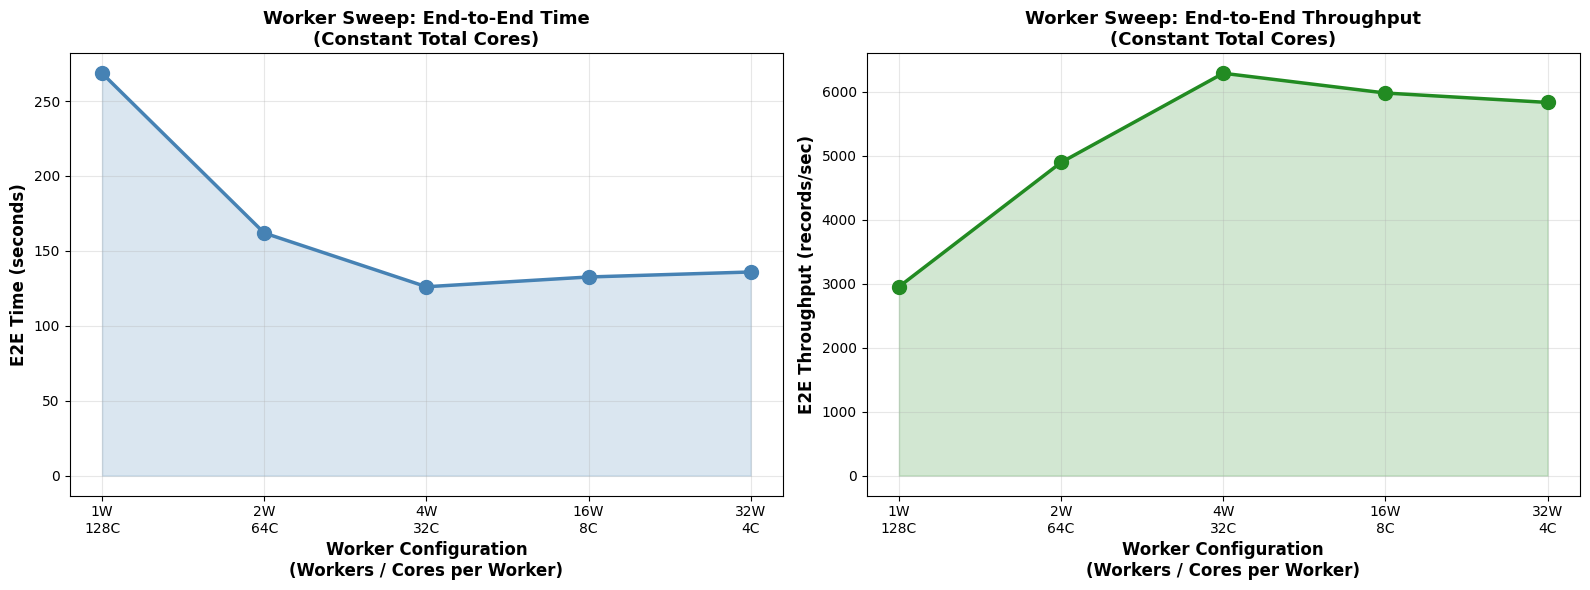

Worker Sweep Performance Analysis:
Config       Workers    Cores/W    Total Cores  E2E Time        E2E Throughput      
--------------------------------------------------------------------------------------------------------------
1W-128C      1          128        128                 268.53s             2953.2 rec/s
2W-64C       2          64         128                 161.92s             4897.5 rec/s
4W-32C       4          32         128                 126.04s             6291.5 rec/s
16W-8C       16         8          128                 132.56s             5982.4 rec/s
32W-4C       32         4          128                 135.90s             5835.3 rec/s


In [100]:
# Worker Sweep Analysis
df_worker = df_worker_sweep.copy()

# Create configuration labels
df_worker['config_name'] = (
    df_worker['num_workers'].astype(str) + 'W-' +
    df_worker['cores_per_worker'].astype(str) + 'C'
)

df_worker['total_cores'] = df_worker['num_workers'] * df_worker['cores_per_worker']
df_worker = df_worker.sort_values('num_workers')

# Create X-axis labels showing both workers and cores per worker
df_worker['x_label'] = (df_worker['num_workers'].astype(str) + 'W\n' +
                        df_worker['cores_per_worker'].astype(str) + 'C')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: E2E Time vs Total Cores
x_positions = range(len(df_worker))
ax1.plot(x_positions, df_worker['E2E_time'], marker='o', linewidth=2.5, markersize=10, color='steelblue')
ax1.fill_between(x_positions, df_worker['E2E_time'], alpha=0.2, color='steelblue')

ax1.set_xticks(x_positions)
ax1.set_xticklabels(df_worker['x_label'], rotation=0, ha='center', fontsize=10)
ax1.set_xlabel('Worker Configuration\n(Workers / Cores per Worker)', fontsize=12, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Worker Sweep: End-to-End Time\n(Constant Total Cores)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Graph 2: E2E Throughput vs Worker Configuration
ax2.plot(x_positions, df_worker['E2E_throughput'], marker='o', linewidth=2.5, markersize=10, color='forestgreen')
ax2.fill_between(x_positions, df_worker['E2E_throughput'], alpha=0.2, color='forestgreen')

ax2.set_xticks(x_positions)
ax2.set_xticklabels(df_worker['x_label'], rotation=0, ha='center', fontsize=10)
ax2.set_xlabel('Worker Configuration\n(Workers / Cores per Worker)', fontsize=12, fontweight='bold')
ax2.set_ylabel('E2E Throughput (records/sec)', fontsize=12, fontweight='bold')
ax2.set_title('Worker Sweep: End-to-End Throughput\n(Constant Total Cores)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("Worker Sweep Performance Analysis:")
print("=" * 110)
print(f"{'Config':<12} {'Workers':<10} {'Cores/W':<10} {'Total Cores':<12} {'E2E Time':<15} {'E2E Throughput':<20}")
print("-" * 110)
for _, row in df_worker.iterrows():
    print(f"{row['config_name']:<12} {row['num_workers']:<10} {row['cores_per_worker']:<10} "
          f"{row['total_cores']:<12} {row['E2E_time']:>13.2f}s {row['E2E_throughput']:>18.1f} rec/s")

## 8. Worker Sweep JVM GC Time Analysis

Analyzing JVM Garbage Collection time across different worker configurations to understand GC overhead patterns.

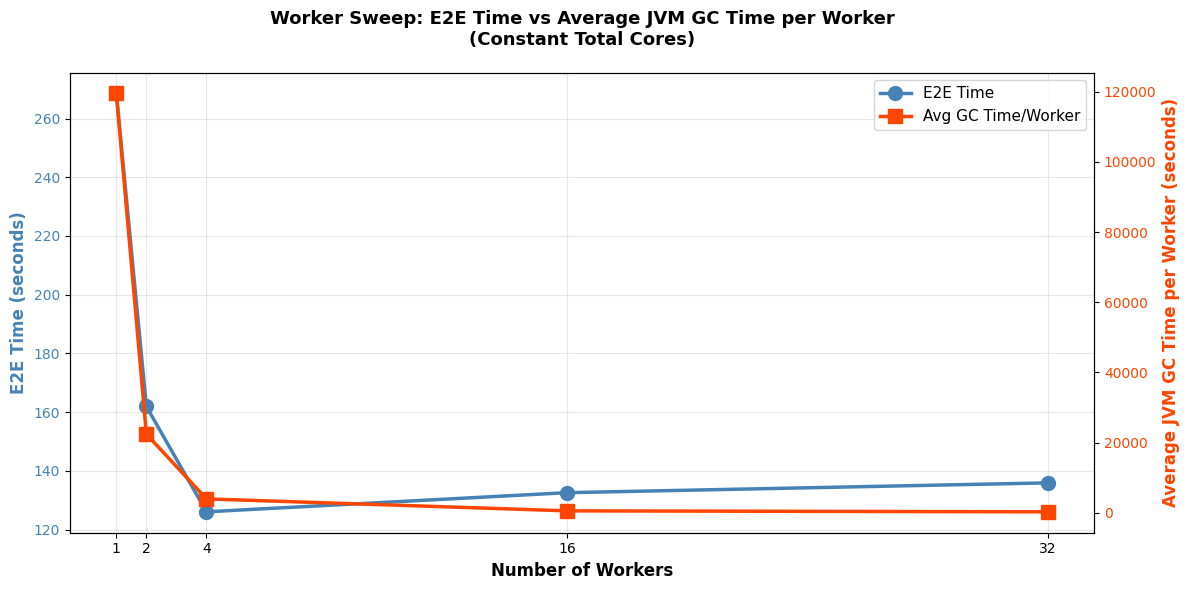

Worker Sweep - E2E Time and Average JVM GC Time Analysis:
Config       Workers    Cores/W    Total Cores  E2E Time        Avg GC Time/Worker  
--------------------------------------------------------------------------------------------------------------
1W-128C      1          128        128                 268.53s          119477.00s
2W-64C       2          64         128                 161.92s           22398.00s
4W-32C       4          32         128                 126.04s            3944.50s
16W-8C       16         8          128                 132.56s             533.88s
32W-4C       32         4          128                 135.90s             262.47s


In [101]:
# Worker Sweep JVM GC Time Analysis
df_worker_gc = df_worker_sweep.copy()

# Create configuration labels
df_worker_gc['config_name'] = (
    df_worker_gc['num_workers'].astype(str) + 'W-' +
    df_worker_gc['cores_per_worker'].astype(str) + 'C'
)

df_worker_gc['total_cores'] = df_worker_gc['num_workers'] * df_worker_gc['cores_per_worker']
df_worker_gc = df_worker_gc.sort_values('num_workers')

# Calculate average GC time per worker
df_worker_gc['Avg_JVM_GC_Time'] = df_worker_gc['Total_JVM_GC_Time'] / df_worker_gc['num_workers']

# Create figure with dual y-axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot E2E Time on left y-axis
color1 = 'steelblue'
ax1.set_xlabel('Number of Workers', fontsize=12, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=12, fontweight='bold', color=color1)
ax1.plot(df_worker_gc['num_workers'], df_worker_gc['E2E_time'], 
         marker='o', linewidth=2.5, markersize=10, color=color1, label='E2E Time')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for Average JVM GC Time
ax2 = ax1.twinx()
color2 = 'orangered'
ax2.set_ylabel('Average JVM GC Time per Worker (seconds)', fontsize=12, fontweight='bold', color=color2)
ax2.plot(df_worker_gc['num_workers'], df_worker_gc['Avg_JVM_GC_Time'], 
         marker='s', linewidth=2.5, markersize=10, color=color2, label='Avg GC Time/Worker')
ax2.tick_params(axis='y', labelcolor=color2)

# Set x-axis ticks to show only the actual number of workers
ax1.set_xticks(df_worker_gc['num_workers'])
ax1.set_xticklabels(df_worker_gc['num_workers'].astype(int), fontsize=10)

# Add title
plt.title('Worker Sweep: E2E Time vs Average JVM GC Time per Worker\n(Constant Total Cores)', 
          fontsize=13, fontweight='bold', pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("Worker Sweep - E2E Time and Average JVM GC Time Analysis:")
print("=" * 110)
print(f"{'Config':<12} {'Workers':<10} {'Cores/W':<10} {'Total Cores':<12} {'E2E Time':<15} {'Avg GC Time/Worker':<20}")
print("-" * 110)
for _, row in df_worker_gc.iterrows():
    print(f"{row['config_name']:<12} {row['num_workers']:<10} {row['cores_per_worker']:<10} "
          f"{row['total_cores']:<12} {row['E2E_time']:>13.2f}s {row['Avg_JVM_GC_Time']:>18.2f}s")
